In [40]:
PATH = 'D:/PycharmProjects/pipeapple_classification_task/efficient_netb0_AdamW_0.001_line_ver2/'

In [41]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
# import shap

In [42]:
# Define a list of data augmentation transformations to apply
augmentations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
]

# Define the transform for the data
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.RandomApply(augmentations, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomApply(augmentations, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_test = torchvision.datasets.ImageFolder(root='E:/Downloads/grad/111_1/data science instroduction/final_project/Pineapple_image', transform=transform_test)
dataset_train = torchvision.datasets.ImageFolder(root='E:/Downloads/grad/111_1/data science instroduction/final_project/Pineapple_image', transform=transform_train)


test_idx = []
train_idx = []
for i in range(len(dataset_test)):
    if (i%5==0): test_idx.append(i)
    else: train_idx.append(i)
train_sub = torch.utils.data.Subset(dataset_train, train_idx)
test_sub = torch.utils.data.Subset(dataset_test, test_idx)

# Create the dataloaders
trainloader = torch.utils.data.DataLoader(train_sub, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_sub, batch_size=64, shuffle=False)

classes = ('stage_501', 'stage_505', 'stage_509', 'stage_601',
           'stage_605', 'stage_609', 'stage_701', 'stage_705', 'stage_709')

model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


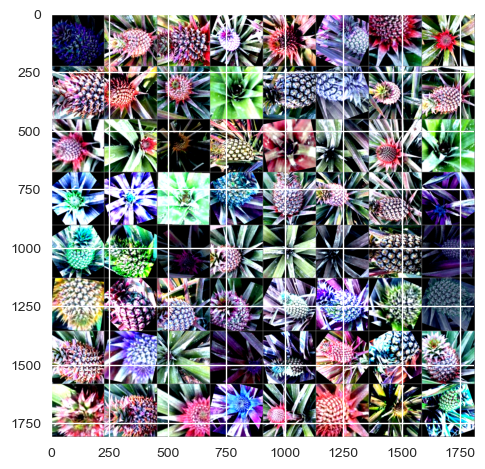

stage_609 stage_609 stage_609 stage_705 stage_509 stage_705 stage_601 stage_505 stage_609


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(9)))

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)


In [45]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            losses.append(loss.item())

    acc = correct / len(dataloader.dataset)
    cm = confusion_matrix(y_true, y_pred)
    return total_loss / len(dataloader), acc, cm, losses

In [46]:
patience = 3
num_epochs = 20
best_val_loss = float('inf')
epochs_without_improvement = 0
acc_test_curve = []
acc_train_curve = []
losses_test_curve = []
losses_train_curve = []
losses_test_itr = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    val_loss, val_acc, cm, losses_test_i = evaluate(model, testloader, criterion)
    print('Epoch {}: train loss = {}, train acc = {}, val loss = {}, val acc = {}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc))
    losses_test_itr.append(losses_test_i)
    losses_test_curve.append(val_loss)
    losses_train_curve.append(train_loss)
    acc_test_curve.append(val_acc)
    acc_train_curve.append(train_acc)
    # Check if the validation loss has improved
    if val_loss < best_val_loss:
        # Update the best validation loss
        best_val_loss = val_loss
        
        # Reset the counter for the number of epochs without improvement
        epochs_without_improvement = 0
    else:
        # Increment the counter for the number of epochs without improvement
        epochs_without_improvement += 1
        
        # Check if the number of epochs without improvement has reached the patience threshold
        if epochs_without_improvement >= patience:
            # Stop the training loop
            print('Early stopping at epoch {}'.format(epoch+1))
            break

Epoch 1: train loss = 1.7178780397643214, train acc = 0.6430555555555556, val loss = 1.9893752187490463, val acc = 0.6222222222222222
Epoch 2: train loss = 0.45754398988640826, train acc = 0.8430555555555556, val loss = 0.7259084930022558, val acc = 0.7638888888888888
Epoch 3: train loss = 0.2554957620475603, train acc = 0.9090277777777778, val loss = 0.9103525072957078, val acc = 0.7861111111111111
Epoch 4: train loss = 0.22607551774253015, train acc = 0.9159722222222222, val loss = 0.4391499909882744, val acc = 0.8777777777777778
Epoch 5: train loss = 0.1802607909168886, train acc = 0.9402777777777778, val loss = 0.0984518718905747, val acc = 0.9694444444444444
Epoch 6: train loss = 0.1704808711681677, train acc = 0.9430555555555555, val loss = 0.26710161624456913, val acc = 0.9333333333333333
Epoch 7: train loss = 0.17601103837723317, train acc = 0.9465277777777777, val loss = 0.29476280774300295, val acc = 0.9083333333333333
Epoch 8: train loss = 0.12799232971409094, train acc = 0.

In [47]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [48]:
losses_curve = flatten(losses_test_itr)

C:\Users\wj4y71u35j4\AppData\Local\Temp\ipykernel_29276\557313359.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


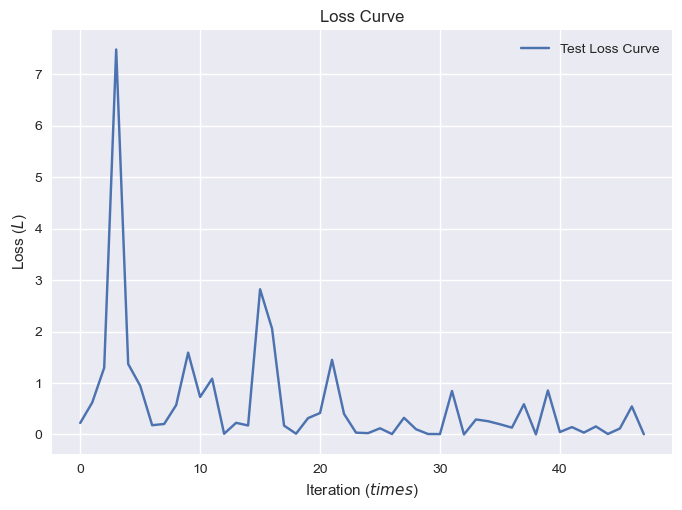

In [49]:
plt.title("Loss Curve")
plt.style.use("seaborn")

plt.plot(losses_curve, label="Test Loss Curve")
plt.xlabel(r"Iteration ($times$)")
plt.ylabel(r"Loss ($L$)")
plt.savefig(os.path.join(PATH, "loss_itr.png"))
plt.legend()
plt.show()

C:\Users\wj4y71u35j4\AppData\Local\Temp\ipykernel_29276\1332182374.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


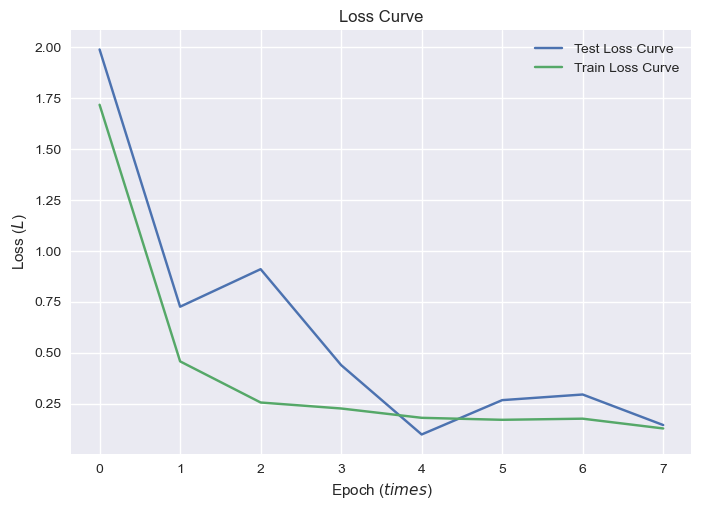

In [50]:
plt.title("Loss Curve")
plt.style.use("seaborn")

plt.plot(losses_test_curve, label="Test Loss Curve")
plt.plot(losses_train_curve, label="Train Loss Curve")
plt.xlabel(r"Epoch ($times$)")
plt.ylabel(r"Loss ($L$)")
plt.savefig(os.path.join(PATH, "loss.png"))
plt.legend()
plt.show()

C:\Users\wj4y71u35j4\AppData\Local\Temp\ipykernel_29276\4002920042.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


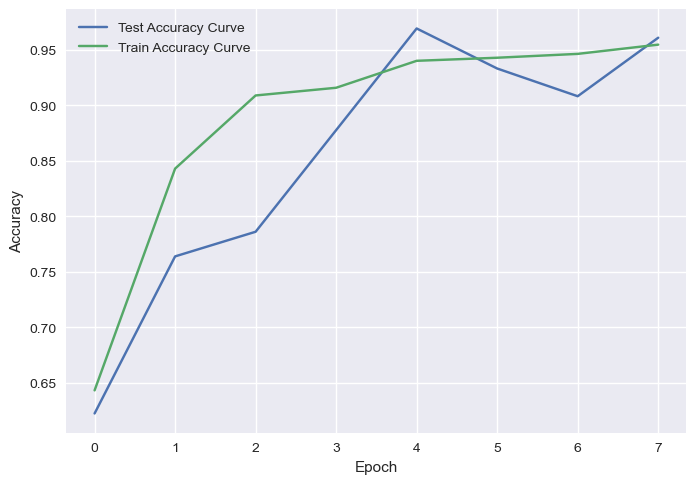

In [51]:
plt.plot(acc_test_curve, label="Test Accuracy Curve")
plt.plot(acc_train_curve, label="Train Accuracy Curve")
plt.style.use("seaborn")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(PATH, "acc.png"))
plt.show()

In [52]:
cm

array([[39,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 39,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 39,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 40,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2, 29,  8,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 40,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 40]], dtype=int64)

In [53]:
torch.save(model.state_dict(), os.path.join(PATH, "weight.pth"))

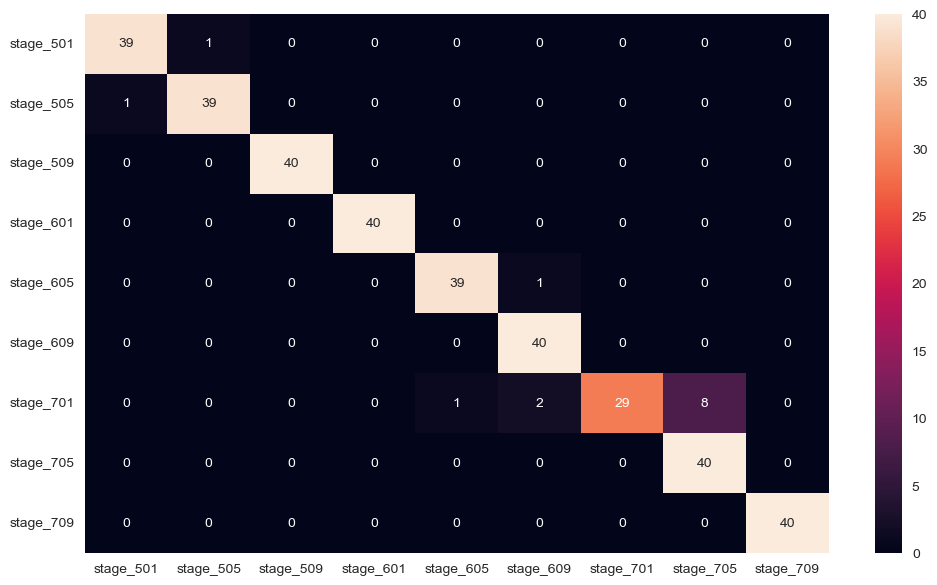

In [54]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig(os.path.join(PATH, "cm.png"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


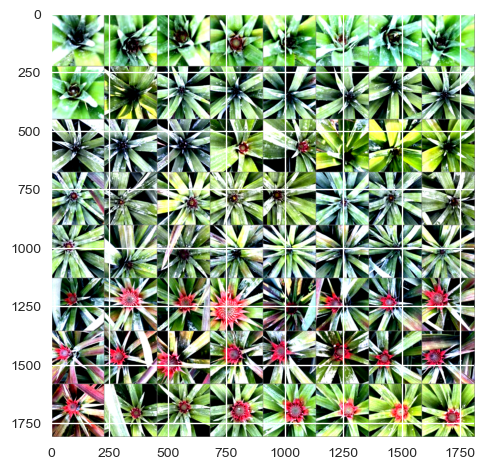

GroundTruth:  stage_501 stage_501 stage_501 stage_501 stage_501 stage_501 stage_501 stage_501 stage_501


In [55]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(9)))

In [56]:
# model = EfficientNet(blocks_args=blocks_args)
# model.load_state_dict(torch.load(PATH))

In [57]:
outputs = model(images)

In [58]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(0)))

Predicted:  


In [59]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 96.11111111111111 %


In [60]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: stage_501 is 97.5 %
Accuracy for class: stage_505 is 97.5 %
Accuracy for class: stage_509 is 100.0 %
Accuracy for class: stage_601 is 100.0 %
Accuracy for class: stage_605 is 97.5 %
Accuracy for class: stage_609 is 100.0 %
Accuracy for class: stage_701 is 72.5 %
Accuracy for class: stage_705 is 100.0 %
Accuracy for class: stage_709 is 100.0 %


Text(0.5, 1.0, 'Images for 7')

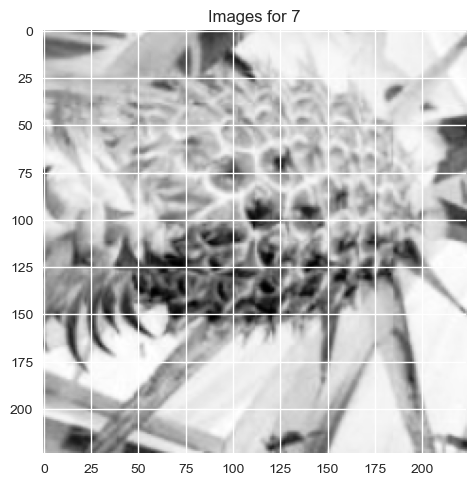

In [61]:
batch = next(iter(trainloader))
images, labels = batch
plt.imshow(images[:1][0][0].numpy())
plt.title(f'Images for {str(labels[:1][0].numpy())}')

In [62]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [63]:
import io
from PIL import Image

# Read the image data into memory
with open('E:/Downloads/grad/111_1/data science instroduction/final_project/Pineapple_image/stage_501/DSC_0462.JPG', 'rb') as f:
    image_data = f.read()

# Create a file-like object from the image data
f = io.BytesIO(image_data)

# Open the image file
img = Image.open(f)

# Display the image
img.show()

In [64]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [65]:
classes_list = ['stage_501', 'stage_505', 'stage_509', 'stage_601',
           'stage_605', 'stage_609', 'stage_701', 'stage_705', 'stage_709']

In [67]:
import torch.nn.functional as F

probs = F.softmax(logits, dim=1)
probs5 = probs.topk(1)
tuple((p,c, classes_list[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.99999976, 0, 'stage_501'),)

In [68]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [69]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [70]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [71]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [00:05<00:00, 178.24it/s]


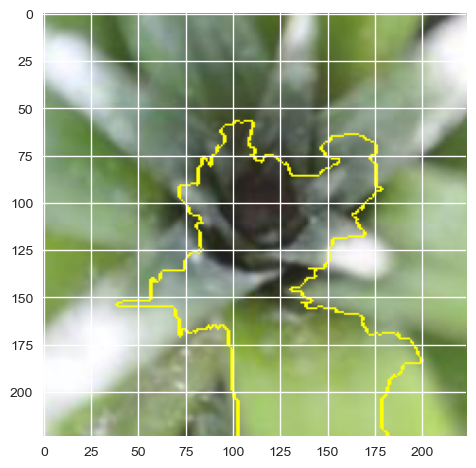

In [72]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)